# Predicción del Precio de la Leche — Documentación

Este notebook evalúa modelos para predecir el precio promedio por litro de leche usando variables macro (Dólar, IPC) y combustibles (biodiesel, gasolina).

Flujo general:
1. Importar librerías.
2. Cargar y preparar datos.
3. Definir función general de entrenamiento.
4. Entrenar modelos para diferentes escenarios (completo, pre/post pandemia, con gasolina).
5. Comparar resultados y visualizar descomposición de la serie.

In [8]:
# ===========================================
# 1. LIBRERÍAS
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


## Librerías

- pandas, numpy: manipulación de datos.
- matplotlib, seaborn: visualización.
- statsmodels: descomposición de series temporales.
- sklearn: modelos y métricas (RandomForest, train_test_split, RMSE, R²).

In [9]:
# ===========================================
# 2. CARGA DE ARCHIVOS
# ===========================================

# Primer CSV (leche, dólar, IPC)
df1 = pd.read_csv("Data/base_con_dolar.csv")

# Segundo CSV (leche, dólar, IPC, gasolinas)
df2 = pd.read_csv("Data/base_con_dolar_gasolina.csv")

# Crear columna de fecha (año + mes)
df1['FECHA'] = pd.to_datetime(dict(year=df1['año'], month=df1['mes'], day=1))
df2['FECHA'] = pd.to_datetime(dict(year=df2['año'], month=df2['mes'], day=1))

# Selección y renombrado de columnas
df1 = df1[['FECHA', 'precio promedio por litro', 'ipc', 'PRECIO_DOLAR']]
df1.columns = ['FECHA', 'LECHE', 'IPC', 'DOLAR']

df2 = df2[['FECHA', 'precio promedio por litro', 'ipc', 'PRECIO_DOLAR',
           'PRECIO_PROMEDIO_BIODIESEL', 'PRECIO_PROMEDIO_CORRIENTE']]
df2.columns = ['FECHA', 'LECHE', 'IPC', 'DOLAR', 'BIODIESEL', 'GASOLINA_CORRIENTE']

# Ordenar cronológicamente
df1 = df1.sort_values('FECHA').reset_index(drop=True)
df2 = df2.sort_values('FECHA').reset_index(drop=True)

print("✅ Datos cargados correctamente:")
print("df1:", df1.shape, "años", df1.FECHA.dt.year.min(), "-", df1.FECHA.dt.year.max())
print("df2:", df2.shape, "años", df2.FECHA.dt.year.min(), "-", df2.FECHA.dt.year.max())


✅ Datos cargados correctamente:
df1: (144, 4) años 2013 - 2024
df2: (52, 6) años 2021 - 2024


## Carga de datos

Se importan dos fuentes:
- `base_con_dolar.csv`: serie principal con DÓLAR e IPC.
- `base_con_dolar_gasolina.csv`: serie con precios de combustibles adicionales (biodiesel, corriente).

Descripción de columnas principales:
- FECHA: índice temporal mensual creado desde año/mes.
- LECHE: precio promedio por litro (target).
- DOLAR, IPC: variables macro exógenas.
- BIODIESEL, GASOLINA_CORRIENTE: variables de combustible para el escenario extendido.

In [ ]:
# ===========================================
# 3. FUNCIÓN GENERAL PARA ENTRENAR MODELOS 
# ===========================================
def entrenar_modelo(df, variables_x, etiqueta="Modelo"):
    df = df.dropna(subset=['LECHE'] + variables_x)

    X = df[variables_x]
    y = df['LECHE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    modelo = RandomForestRegressor(n_estimators=200, random_state=42)
    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)

    # 👉 Corrección: calcula RMSE manualmente
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)

    print(f"\n🔹 {etiqueta}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")

    # Gráfico de comparación real vs predicción
    plt.figure(figsize=(10,4))
    plt.plot(y_test.index, y_test, label='Real', color='red')
    plt.plot(y_test.index, pred, label='Predicho', color='blue', alpha=0.7)
    plt.title(f"🔮 {etiqueta}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Importancia de variables
    importancia = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(6,3))
    sns.barplot(x=importancia.values, y=importancia.index, palette="viridis")
    plt.title(f"📊 Importancia de variables ({etiqueta})")
    plt.show()

    return {"Modelo": etiqueta, "RMSE": rmse, "R2": r2}


## Función entrenar_modelo

Detalles:
- Entrada: DataFrame `df` y lista de variables predictoras `variables_x`.
- Ajuste: Split 80/20 sin shuffle para preservar orden temporal (validación temporal simple).
- Modelo: RandomForestRegressor con 200 árboles por defecto.
- Salida: métricas RMSE y R²; gráficas de predicción y barra de importancia de variables.

Nota: Si se requiere validación robusta temporal (TimeSeriesSplit) o búsquedas de hiperparámetros, incorporar en próximos pasos.


🔹 Serie completa (Dólar + IPC)
RMSE: 255.09
R²: -1.165


/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


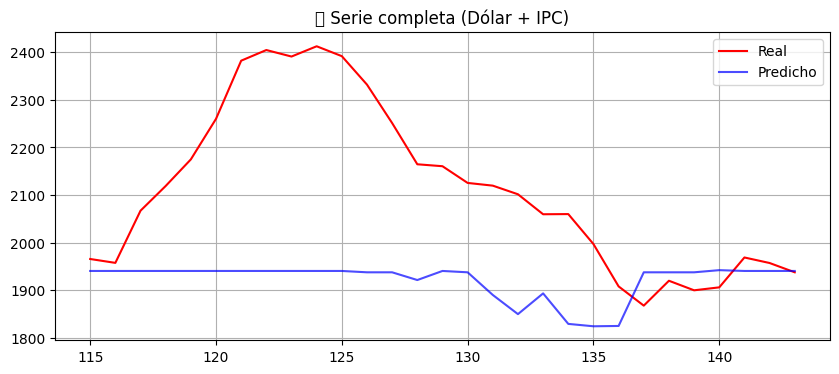

/tmp/ipykernel_18134/2003823875.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancia.values, y=importancia.index, palette="viridis")
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


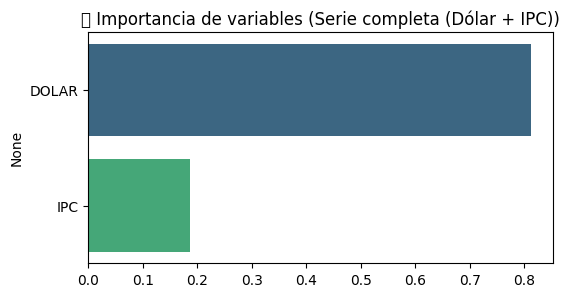


🔹 Pre-pandemia (2013–2018)
RMSE: 32.41
R²: -9.438


/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


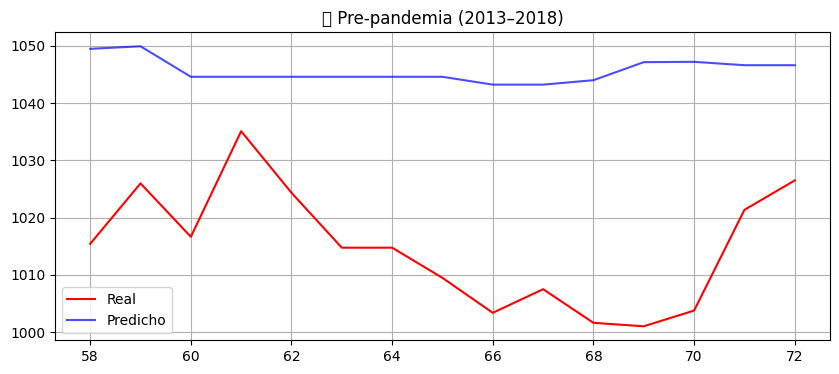

/tmp/ipykernel_18134/2003823875.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancia.values, y=importancia.index, palette="viridis")
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


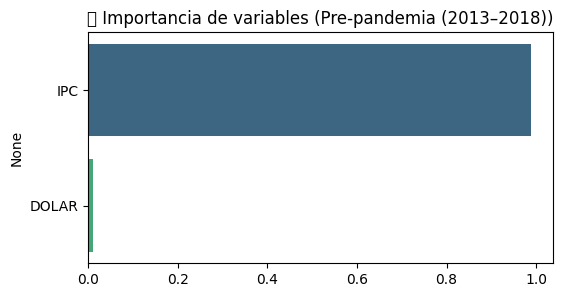


🔹 Post-pandemia (2019–2024)
RMSE: 132.07
R²: -0.991


/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


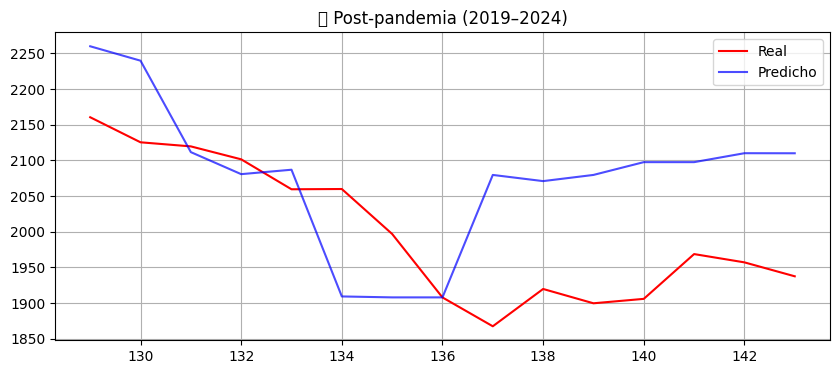

/tmp/ipykernel_18134/2003823875.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancia.values, y=importancia.index, palette="viridis")
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


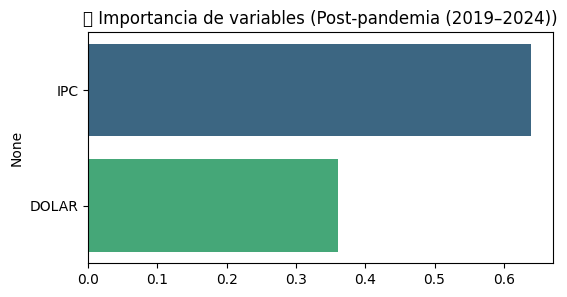


🔹 Con gasolina (2021–2024)
RMSE: 194.43
R²: -9.212


/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


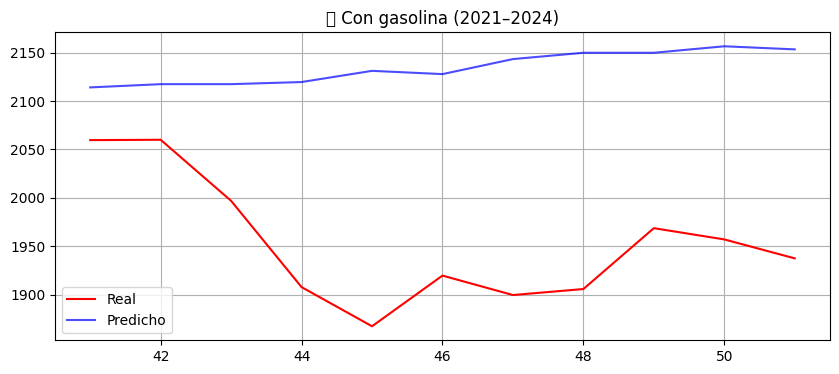

/tmp/ipykernel_18134/2003823875.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancia.values, y=importancia.index, palette="viridis")
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


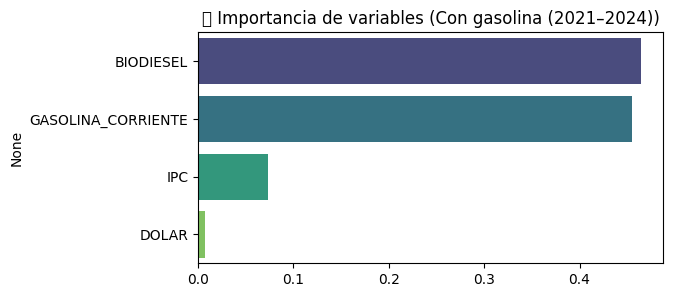

In [13]:
# ===========================================
# 4. ENTRENAR LOS 4 MODELOS
# ===========================================

resultados = []

# 1️⃣ Serie completa (dólar + IPC)
resultados.append(entrenar_modelo(df1, ['DOLAR', 'IPC'], "Serie completa (Dólar + IPC)"))

# 2️⃣ Pre-pandemia (2013–2018)
pre = df1[df1['FECHA'].dt.year <= 2018]
resultados.append(entrenar_modelo(pre, ['DOLAR', 'IPC'], "Pre-pandemia (2013–2018)"))

# 3️⃣ Post-pandemia (2019–2024)
post = df1[df1['FECHA'].dt.year >= 2019]
resultados.append(entrenar_modelo(post, ['DOLAR', 'IPC'], "Post-pandemia (2019–2024)"))

# 4️⃣ Modelo extendido (2021–2024, incluye gasolinas)
resultados.append(entrenar_modelo(df2, ['DOLAR', 'IPC', 'BIODIESEL', 'GASOLINA_CORRIENTE'],
                                  "Con gasolina (2021–2024)"))


## Escenarios y entrenamiento

- Serie completa: todo el período disponible con Dólar e IPC.
- Pre-pandemia: datos hasta 2018 (incluye posibilidad de comparar dinámicas).
- Post-pandemia: desde 2019 en adelante para ver cambios en la dinámica.
- Con gasolina: escenario extendido 2021–2024 incluyendo BIODIESEL y GASOLINA_CORRIENTE.

Cada escenario se entrena con la función `entrenar_modelo` y se registran las métricas.

/tmp/ipykernel_18134/2867887850.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Modelo', data=res_df, palette='coolwarm')
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


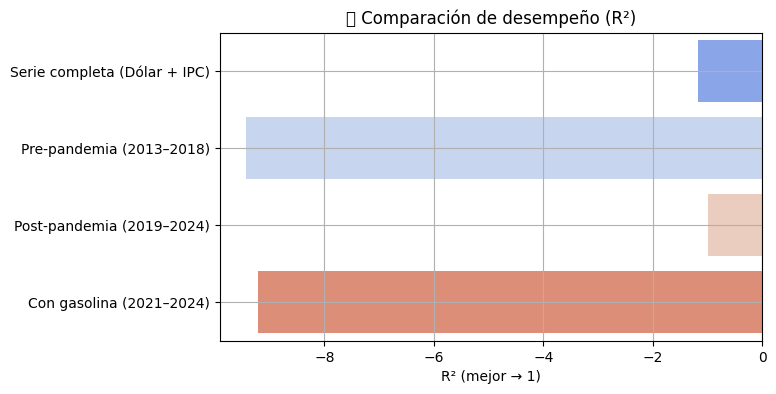

,Modelo,RMSE,R2
0,Serie completa (Dólar + IPC),255.090643,-1.165143
1,Pre-pandemia (2013–2018),32.406003,-9.438116
2,Post-pandemia (2019–2024),132.065814,-0.991377
3,Con gasolina (2021–2024),194.426999,-9.211652


In [14]:
# ===========================================
# 5. COMPARACIÓN GENERAL DE RESULTADOS
# ===========================================
res_df = pd.DataFrame(resultados)
plt.figure(figsize=(7,4))
sns.barplot(x='R2', y='Modelo', data=res_df, palette='coolwarm')
plt.title("📈 Comparación de desempeño (R²)")
plt.xlabel("R² (mejor → 1)")
plt.ylabel("")
plt.grid(True)
plt.show()

res_df


## Comparación de métricas

- Se construye un DataFrame `res_df` con RMSE y R² por escenario.
- Se visualiza la comparación por R² para identificar modelos más predictivos.
- Considerar también comparar por MAE o RMSE para una evaluación más robusta de error.

/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


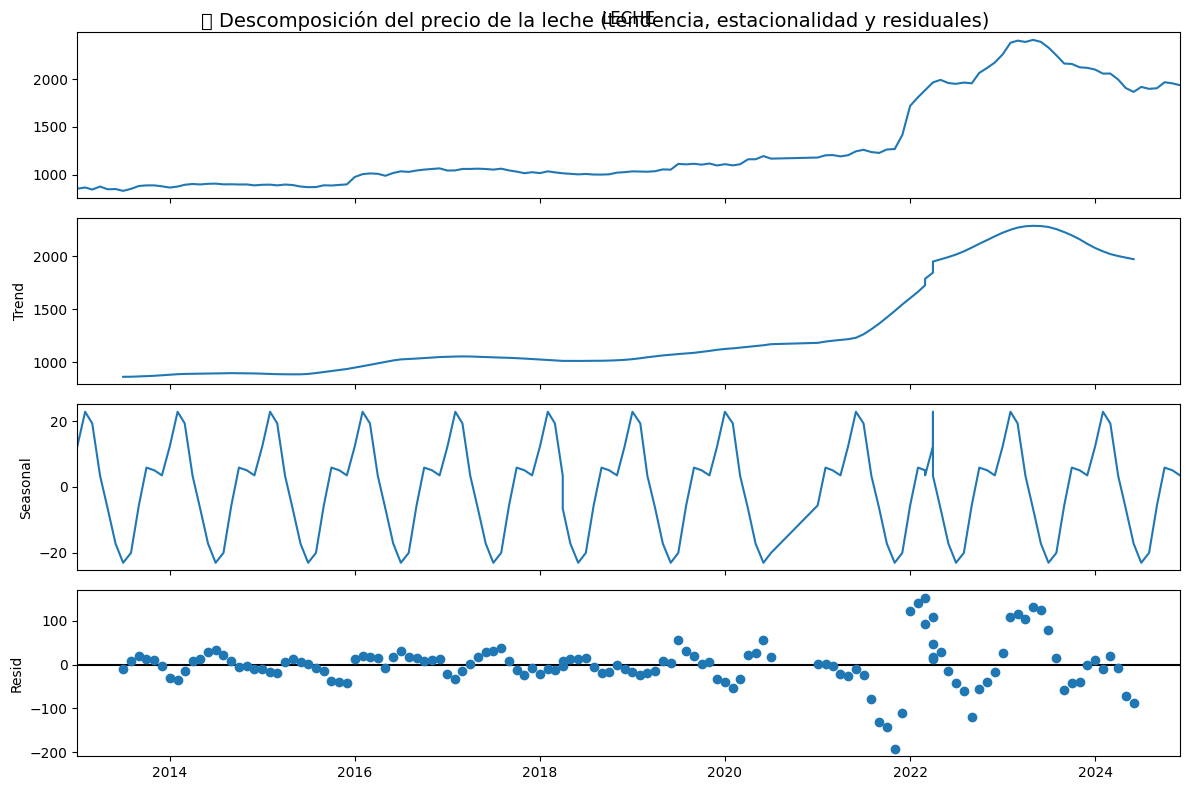

In [15]:
# ===========================================
# 6. DESCOMPOSICIÓN SERIE TEMPORAL
# ===========================================
df_ts = df1.set_index('FECHA')
decomp = seasonal_decompose(df_ts['LECHE'], model='additive', period=12)

plt.rcParams.update({'figure.figsize': (12,8)})
decomp.plot()
plt.suptitle("🔍 Descomposición del precio de la leche (tendencia, estacionalidad y residuales)", fontsize=14)
plt.show()


## Descomposición temporal

La función `seasonal_decompose` separa la serie en tendencia, estacionalidad y residuales (modelo aditivo).
Esto permite identificar patrones estacionales anuales y comportamiento de la tendencia.
